# importemos primero algunas bibliotecas que nos vayan a ser de utilididad.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import cv2
from PIL import Image
import io
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

print(tf.__version__)

2.18.0


**Alzheimer의 이미지를 통한 검출: Dataset 문제와 구조**
알츠하이머병은 치매의 가장 흔한 원인으로, 주로 65세 이상의 노인에게 영향을 미치며, 기억력의 점진적인 손실을 초래합니다. 이 프로젝트는 뇌의 MRI 이미지를 네 가지 카테고리로 분류하여 조기 진단을 통한 치료 방법을 모색합니다.

**Dataset 구조**

**Train split:** 모델 훈련용
**Test split:** 모델 평가용
**저장 형식: Parquet** (이미지 처리에는 최적화되지 않음)
각 Parquet 파일은 다음을 포함합니다:

**이미지: 직렬화된 형식**
**레이블: 이미지가 속하는 클래스 (0, 1, 2, 3)**
카테고리 설명
- '0': Mild Demented (가벼운 치매)
- '1': Moderate Demented (중간 정도의 치매)
- '2': Non Demented (치매 증상 없음)
- '3': Very Mild Demented (매우 가벼운 치매)
**데이터셋 정보**
- Train split:
 - 이름: train
 - 바이트 수: 22,560,791.2
 - 예제 수: 5,120
**Test split:**
 - 이름: test
 - 바이트 수: 5,637,447.08
 - 예제 수: 1,280
- 다운로드 크기: 28,289,848 bytes
- 데이터셋 전체 크기: 28,198,238.28 bytes

**인용 정보**
이 데이터셋을 연구 또는 의료 응용 프로그램에 사용할 경우, 다음 출처를 인용해 주시기 바랍니다:


@dataset{alzheimer_mri_dataset,
  author = {Falah.G.Salieh},
  title = {Alzheimer MRI Dataset},
  year = {2023},
  publisher = {Hugging Face},
  version = {1.0},
  url = {https://huggingface.co/datasets/Falah/Alzheimer_MRI}
}

**추가 주제: 알츠하이머병에 대한 조기 경고 지표**
알츠하이머병의 조기 발견은 환자의 삶의 질을 향상시킬 수 있는 핵심입니다. 다음은 조기 경고 신호입니다:

 - 기억력 저하: 최근의 사건이나 대화 내용을 잊어버리는 경향이 있습니다.
 - 일상생활의 변화: 평소 즐기던 활동을 피하거나, 흥미를 잃는 경우가 증가합니다.
 - 의사결정 혼란: 간단한 재정적 결정을 내리는 데 어려움을 겪는 모습이 나타납니다.
 - 사회적 고립: 외롭고, 친구들과의 만남을 피하는 경향이 있습니다.

이러한 조기 경고 신호를 인지하고, 필요한 경우 즉시 전문의에게 상담받는 것이 중요합니다. 예를 들어, 정기적인 정신 건강 검진과 언어 및 기억력 테스트는 초기 단계에서의 알츠하이머병 식별에 도움을 줄 수 있습니다. 🙂publisher = {Hugging Face},
  version = {1.0},
  url = {https://huggingface.co/datasets/Falah/Alzheimer_MRI}
}

다음 단계는 Parquet 파일에서 데이터를 추출하고 변환하는 것입니다.

훈련(train)과 테스트(test) 데이터셋 모두 Parquet 형식으로 제공되므로, pd.read_parquet를 사용하여 이미지를 추출할 수 있습니다.

이 과정을 통해 우리는 이미지 데이터를 적절한 형식으로 변환하여 모델 훈련에 사용할 수 있게 됩니다.

In [21]:
train ='train-00000-of-00001-c08a401c53fe5312.parquet'
test = 'test-00000-of-00001-44110b9df98c5585.parquet'
categorias = {
    0: 'Mild_Demented',
    1: 'Moderate_Demented',
    2: 'Non_Demented',
    3: 'Very_Mild_Demented'
}
data_train = pd.read_parquet(train)
data_test = pd.read_parquet(test)
data_train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


이미지를 행렬 형태로 작업할 수 있도록 몇 가지 변환을 수행해야 합니다. 일반적인 변환 과정은 다음과 같습니다:

1. 이미지 디코딩: Parquet 파일에서 직렬화된 이미지 데이터를 읽고, 이를 이미지 형식으로 디코딩합니다.

2. 크기 조정: 모든 이미지를 동일한 크기로 조정하여 모델에 일관된 입력을 제공합니다. 예를 들어, 224x224 픽셀로 조정할 수 있습니다.

3. 정규화: 픽셀 값을 0과 1 사이의 값으로 정규화하여 모델 학습 시 안정성을 높입니다. 일반적으로, 각 픽셀 값을 255로 나누는 방식으로 수행합니다.

4. 형태 변환: 이미지를 NumPy 배열로 변환하여 모델의 입력으로 사용할 수 있도록 합니다.

이러한 변환을 수행한 후, 이미지를 모델에 입력할 준비가 됩니다.



주어진 코드는 Parquet 파일에서 이미지를 추출하고, 이를 디코딩하여 표시하는 과정

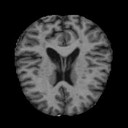

In [29]:
img_dict = data_train['image'][0]
byte_string = img_dict['bytes']
nparr = np.frombuffer(byte_string, np.uint8)
img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)

image = Image.open(io.BytesIO(byte_string))
display(image)

In [33]:
def extraccion_y_transformacion(images_set):
    et_list_images = []
    images_bytes = images_set['image']
    for img_dict in images_bytes:
        byte_string = img_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        et_list_images.append(img)
    return et_list_images

def visualizar_imagenes(image_set, categorias, limit=5):
    fig, axes = plt.subplots(1, limit, figsize=(10, 5))
    image_bytes = image_set['image']

    for i, (ax, row) in enumerate(zip(axes, image_set.iterrows())):
        img_dict = row[1]['image']
        label = row[1]['label']
        name = categorias[label]
        
        byte_string = img_dict['bytes']
        image = Image.open(io.BytesIO(byte_string))
        
        ax.imshow(image, cmap='gray')
        ax.set_title(name) 
        ax.axis('off')
        
        if i + 1 == limit:
            break

    plt.tight_layout()
    plt.show()

In [35]:
train_transformado = extraccion_y_transformacion(data_train)
test_transformado = extraccion_y_transformacion(data_test)
print(train_transformado[:1])

[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]


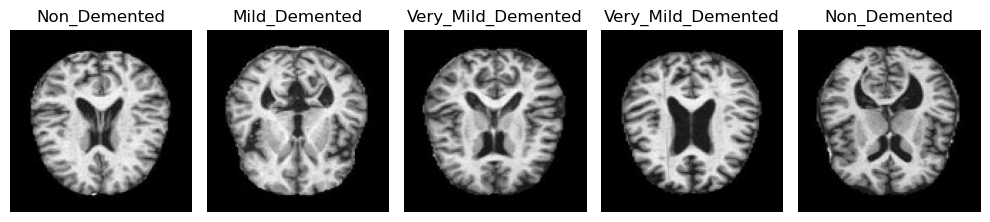

In [37]:
visualizar_imagenes(data_train, categorias, limit=5)

여기서 우리는 이미지를 올바르게 로드하였으며, 이를 모델에 전달하여 학습을 진행할 준비가 되었습니다.

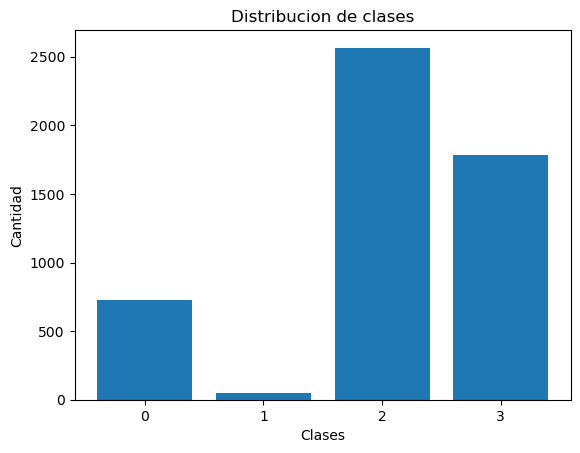

In [40]:
y_test = []
for label in data_test['label']:
    y_test.append(label)

y_train = []
for label in data_train['label']:
    y_train.append(label)
    
y_train = np.array(y_train)
y_test = np.array(y_test)

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Clases')
plt.ylabel('Cantidad')
plt.title('Distribucion de clases')
plt.xticks(unique) 
plt.show()

우리는 클래스가 균형을 이루고 있지 않다는 점을 알 수 있습니다. 따라서 이를 보완하기 위해 데이터 증강을 고려할 수 있습니다. 하지만 현재로서는 데이터 분포에 대해 아무런 조치를 취하지 않고 모델이 어떻게 작동하는지 살펴보겠습니다.


레이블 변수를 원-핫 인코딩합니다.
예를 들어, 레이블이 2인 경우, 이는 다음과 같이 표현되어야 합니다: [0, 0, 1, 0]

In [44]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=4)
y_test = tf.one_hot(y_test.astype(np.int32), depth=4)
y_train

<tf.Tensor: shape=(5120, 4), dtype=float32, numpy=
array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)>

# 데이터를 표준화하고 정규화

## 정규화

In [9]:
train_transformado = np.array(train_transformado)/255
test_transformado = np.array(test_transformado)/255

## 표준화

In [50]:
train_transformado = [np.expand_dims(img, axis=-1) for img in train_transformado] # agregar el canal de escala de grises
test_transformado = [np.expand_dims(img, axis=-1) for img in test_transformado]
#test_transformado = [np.expand_dims(img, axis=-1) for img in test_transformado]
train_transformado = np.array(train_transformado)
test_transformado = np.array(test_transformado)
train_transformado[0].shape

(128, 128, 1)

In [52]:
train_transformado.shape

(5120, 128, 128, 1)

In [54]:
class MinMaxScaler3D(MinMaxScaler):
    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

scaler = MinMaxScaler3D()
train_scaled = [scaler.fit_transform(X=img) for img in train_transformado]
train_scaled = np.array(train_scaled)
test_scaled = [scaler.fit_transform(X=img) for img in test_transformado]
test_scaled = np.array(test_scaled)

In [56]:
train_scaled.shape

(5120, 128, 128, 1)

# Keras를 사용하여 모델을 구축하는 과정을 설명하겠습니다. 여기서는 간단한 CNN(합성곱 신경망) 모델을 예로

In [61]:
from tensorflow ihttp://localhost:8888/notebooks/Alzheimer%20MRI%20-%20TinyCNN/alzheimer-project-tensorflow(4-Classification).ipynb?#hagamos-el-modelo-con-kerasmport keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Sequential, initializers
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam

SyntaxError: invalid decimal literal (1867793672.py, line 1)

In [63]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Sequential, initializers
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam

In [65]:
#optimizer = Adam()
optimizer = Adam(
    learning_rate=0.001,  # Tasa de aprendizaje
    beta_1=0.9,          # Decay rate del primer momento
    beta_2=0.999,        # Decay rate del segundo momento
    epsilon=1e-07        # Término de suavizado
)

model = Sequential([
    layers.Input(shape=(128,128,1)),
    
    layers.Conv2D(64, kernel_size=(2,2), activation='relu',kernel_initializer = initializers.HeNormal(seed=42), padding='same'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    #layers.Dropout(0.25),
    
    layers.Conv2D(64,kernel_size=(2,2), activation='relu', kernel_initializer = initializers.HeNormal(seed=42), padding='same'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    #layers.Dropout(0.25),

    layers.Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer = initializers.HeNormal(seed=42), padding='same'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    #layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(categorias), activation='softmax')
])

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

**신경망 아키텍처**

**네트워크 설계**
우리는 MRI 이미지를 4개의 클래스(치매 수준에 따라)로 분류하기 위해 설계된 합성곱 신경망(CNN)을 가지고 있습니다.

1. **입력**:

Parquet 파일을 처리하여 작업할 수 있는 이미지로 변환한 후, 다음과 같은 조건을 갖습니다. 이미지를 재조정하지 않은 이유는 가능한 한 모든 세부 사항을 잘 포착하기 위함입니다.

입력 크기: (128, 128, 1), 회색조 이미지입니다.

2. **합성곱 층**:

이미지를 처리할 때는 합성곱 층을 사용하는 것이 필수적입니다. 

합성곱 층은 경계, 텍스처 등과 같은 특성을 식별합니다. 필터의 수는 더 깊은 층에서 더 복잡한 패턴을 포착할 수 있게 해줍니다. 우리 네트워크에는 3개의 합성곱 층이 있습니다:

첫 번째 및 두 번째 층: 64개의 필터, 크기 (2,2), ReLU 활성화, HeNormal 초기화.
세 번째 층: 128개의 필터, 크기 (3,3), ReLU 활성화, HeNormal 초기화.

3. **풀링**:

MaxPooling은 특성의 공간 해상도를 줄이는 동시에 중요한 정보를 유지하여 과적합의 위험을 감소시킵니다.

MaxPooling (2,2)는 각 합성곱 후에 적용됩니다.

4. **Flatten 및 피드포워드 네트워크**:

합성곱 층 후에, 이전 층의 출력을 사용하여 분류를 수행하는 두 개의 밀집 층이 있습니다.

Flatten: 2D 출력을 1D 벡터로 변환합니다.
밀집 층 1:
256개의 유닛, ReLU 활성화.
밀집 층 2:
4개의 유닛, 클래스 수에 해당하며, 소프트맥스 활성화를 사용하여 각 클래스에 대한 확률을 예측합니다.

5. **정규화**:

Dropout(0.25): 훈련 중에 무작위로 일부 뉴런을 비활성화하여 일반화를 개선합니다.

활성화 함수
**ReLU**: 대부분의 층에서 비선형성을 처리하고 기울기가 너무 작아지는 것을 방지하기 위해 사용합니다.
**Softmax**: 출력 층에서만 사용하여 로짓을 다중 클래스 분류를 위한 확률로 변환합니다.

**하이퍼파라미터**
1. 학습률 (learning_rate=0.001): 이 값은 우리의 모델에 이상적이었습니다.

2. Adam 옵티마이저: 대부분의 경우에 가장 잘 작동합니다.

    - beta_1 = 0.9 및 beta_2 = 0.999: 이 값들은 더 나은 안정성을 위해 사용합니다.
    - epsilon = 1e-07: 이 매개변수는 0으로 나누는 것을 방지하기 위해 사용합니다.
3. HeNormal 초기화: 이 가중치 초기화기는 ReLU 활성화에만 사용되며, 기울기가 폭주하거나 소실되는 것을 방지하기 위한 목적입니다.

**동기**
 1. 합성곱 층: 이미지를 처리할 때 합성곱 층을 사용하는 것은 표준입니다.
 2. 네트워크 깊이: 우리의 네트워크는 깊지 않으며, 레이어 수는 적지만 좋은 분류 수준을 달성하는 데 필요한 구조입니다. 더 많은 층과 적은 층으로 실험해 보았지만, 적은 층에서는 정확도가 0.5 또는 0.6을 넘기지 못했습니다. 반면 더 많은 층을 추가했을 때는 결과가 비슷하게 유지되었습니다. 그래서 현재의 구조를 유지하기로 했습니다.
 3. 정규화: 단 하나의 dropout만 사용했으며, 이로 인해 좋은 결과를 얻을 수 있었습니다.
 4. 옵티마이저: Adam을 사용하여 높은 효율성과 다양한 문제에 적응할 수 있는 능력을 활용했습니다.ncia y capacidad de adaptarse a distintos problemas.

## 모델 훈련하기

In [71]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.995):
            print("\nReached 99.5% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()
history = model.fit(
    train_scaled, 
    y_train,
    batch_size=10,
    epochs=20,
    validation_split=0.1,
    callbacks=[callbacks]
)

Epoch 1/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 74s 153ms/step - accuracy: 0.4948 - loss: 2.0325 - val_accuracy: 0.5859 - val_loss: 0.9122
Epoch 2/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 68s 148ms/step - accuracy: 0.5769 - loss: 0.9193 - val_accuracy: 0.6016 - val_loss: 0.9166
Epoch 3/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 67s 146ms/step - accuracy: 0.6314 - loss: 0.8181 - val_accuracy: 0.6602 - val_loss: 0.7592
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 68s 147ms/step - accuracy: 0.6818 - loss: 0.7114 - val_accuracy: 0.6680 - val_loss: 0.6794
Epoch 5/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 69s 149ms/step - accuracy: 0.7463 - loss: 0.5832 - val_accuracy: 0.7910 - val_loss: 0.4912
Epoch 6/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 66s 143ms/step - accuracy: 0.8156 - loss: 0.4455 - val_accuracy: 0.8164 - val_loss: 0.4279
Epoch 7/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 68s 146ms/step - accuracy: 0.8661 - loss: 0.3355 - val_accuracy: 0.8594 - val_loss: 0.3138
Epoch 8/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 72s 155ms/step - accuracy: 0.9146 - loss: 0

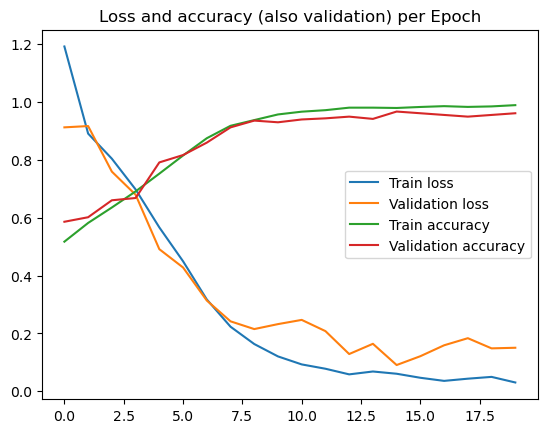

In [73]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Loss and accuracy (also validation) per Epoch')
plt.show()

In [75]:
history.model.layers

[<Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <MaxPooling2D name=max_pooling2d_2, built=True>,
 <Flatten name=flatten, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

In [77]:
w, b = history.model.layers[0].get_weights()

In [79]:
b.shape

(64,)

# 모델의 정확도를 평가

In [82]:
test_loss, test_acc = model.evaluate(test_scaled, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

40/40 - 6s - 151ms/step - accuracy: 0.9586 - loss: 0.2098
Test accuracy: 0.9585937261581421


In [84]:
predictions = model.predict(test_scaled)

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step


In [87]:
predictions[0]

array([1.5463296e-05, 3.0011733e-11, 6.3446659e-04, 9.9935001e-01],
      dtype=float32)

예측 결과는 4개의 숫자로 구성된 배열입니다. 이 숫자는 모델이 4개의 클래스 각각에 대해 이미지에 대한 신뢰 수준을 나타냅니다. 이제 가장 높은 신뢰 수준을 어떻게 얻는지 살펴보겠습니다.

In [90]:
np.argmax(predictions[0])

3

모델은 첫 번째 이미지가 클래스 3(즉, **Very Mild Demented**)에 속할 가능성이 높다고 판단하고 있습니다. 이를 통해 모델이 해당 이미지에 대해 가장 높은 신뢰도를 가지고 있다는 의미입니다.

In [93]:
data_test['label'][0]

3

맞습니다. 모델이 예측한 대로 정확하게 분류되었다면 좋은 결과입니다. 하지만 모델을 다시 훈련할 때 가중치를 저장하지 않으면, 매번 훈련할 때마다 결과가 달라질 수 있습니다. 이는 초기화된 가중치와 훈련 과정의 무작위성 때문에 발생하는 현상입니다. 따라서 모델의 성능을 일관되게 평가하려면 가중치를 저장하고 불러오는 것이 중요합니다.

In [96]:
from sklearn.metrics import classification_report
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
report = classification_report(true_classes, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       172
           1       0.93      0.93      0.93        15
           2       0.96      0.97      0.97       634
           3       0.95      0.95      0.95       459

    accuracy                           0.96      1280
   macro avg       0.95      0.94      0.95      1280
weighted avg       0.96      0.96      0.96      1280



# 시각화

In [98]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(categorias[predicted_label],
                                100*np.max(predictions_array),
                                categorias[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(4))
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

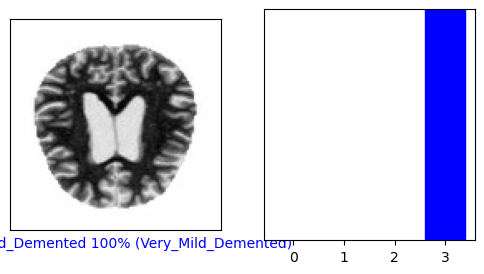

In [101]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], np.argmax(y_test, axis=1), test_scaled)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], np.argmax(y_test, axis=1))
plt.show()

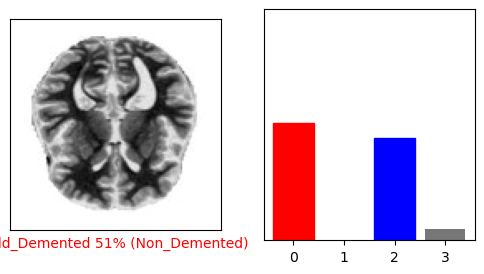

In [103]:
i = 8
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], np.argmax(y_test, axis=1), test_scaled)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], np.argmax(y_test, axis=1))
plt.show()

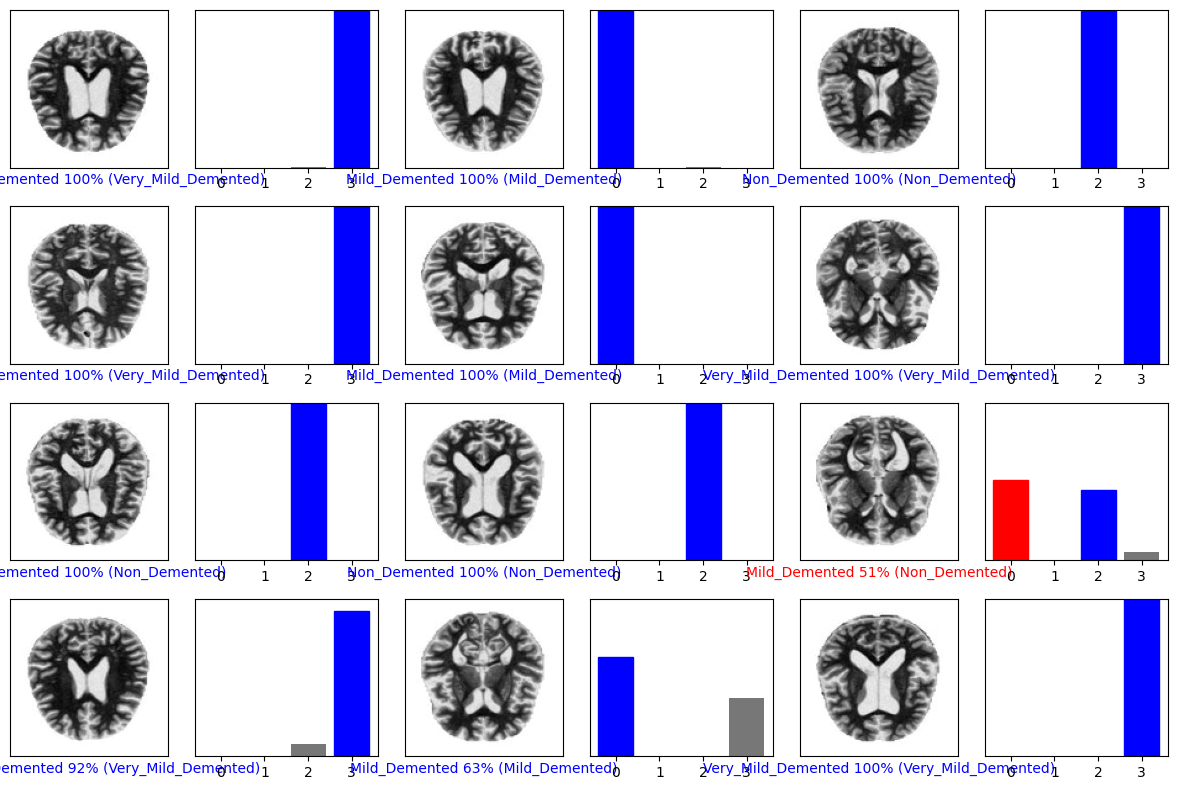

In [105]:
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], np.argmax(y_test, axis=1), test_scaled)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], np.argmax(y_test, axis=1))
plt.tight_layout()
plt.show()

# Fuente del Dataset

@dataset{alzheimer_mri_dataset,\
  author = {Falah.G.Salieh},\
  title = {Alzheimer MRI Dataset},\
  year = {2023},\
  publisher = {Hugging Face},\
  version = {1.0},\
  url = {https://huggingface.co/datasets/Falah/Alzheimer_MRI}\
}